In [117]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.optimize import curve_fit, minimize
from scipy.signal import find_peaks
import emcee

In [118]:
name = 'DR21W'
I_hdu = fits.open(name + '_I.FITS')
I_d = np.squeeze(I_hdu[0].data)
I_h = I_hdu[0].header

V_hdu = fits.open(name + '_V.FITS')
V_d = np.squeeze(V_hdu[0].data)
V_h = V_hdu[0].header

# Reading the spectrum of the selected pixel
x = 127
y = 127
spec = I_d[:, x, y]
V = V_d[:, x, y]
# plt.plot(spec)
# plt.plot(V)
# plt.imshow(I_d[128, :, :], origin='lower')

In [119]:
def nGauss(theta, x):
    """
    Function to fit the spectrum with a sum of Gaussian functions
    """
    y = np.zeros_like(x)
    for i in range(0, len(theta), 3):
        amp = theta[i]
        ctr = theta[i+1]
        wid = theta[i+2]
        y = y + amp * np.exp( -0.5 * ((x - ctr)/wid)**2)
    return y

# Scipy curve_fit and emcee have different implementations on the placement of independent variables, hence the two gaussian functions
def nGauss_scipy(x, *theta):
    """
    Function to fit the spectrum with a sum of Gaussian functions
    """
    y = np.zeros_like(x)
    for i in range(0, len(theta), 3):
        amp = theta[i]
        ctr = theta[i+1]
        wid = theta[i+2]
        y = y + amp * np.exp( -0.5 * ((x - ctr)/wid)**2)
    return y

def log_likelihood(theta, x, y, dy):
    y_model = nGauss(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) + (y - y_model) ** 2 / (2 * dy) ** 2)

# Assumes uniform priors, returning 0 for all theta input
def log_posterior(theta, x, y, dy):
    return 0 + log_likelihood(theta, x, y, dy)

In [120]:
# initiate an array of uniform error from the standard deviation of the baseline noise
err = np.ones(len(spec)) * np.std(spec[0:int(peaks[0] - 2 * info['widths'][0])])

# Finds initial guesses for the parameters
peaks, info = find_peaks(spec, height=0, width=0.01 * len(spec), prominence=0.5*np.max(spec))
guess = []
for i in range(len(peaks)):
    guess.append(spec[peaks[i]] * 0.5) # Amplitude
    guess.append(peaks[i] - info['widths'][i] / 4) # Center
    guess.append(info['widths'][i] / 2) # Width

    guess.append(spec[peaks[i]] * 0.5) # Amplitude
    guess.append(peaks[i] + info['widths'][i] / 4) # Center
    guess.append(info['widths'][i] / 2) # Width

In [121]:
# Maximum Likelihood fit
nll = lambda *args: -log_likelihood(*args)
initial = guess
soln = minimize(nll, initial, args=(np.arange(0, len(spec), 1.), spec, err))
ML_fit = nGauss(soln.x, np.arange(0, len(spec), 1.))

#Least Square
popt, pcov = curve_fit(nGauss_scipy, np.arange(0, len(spec), 1.), spec, p0=guess, maxfev=1000000)
LS_fit = nGauss_scipy(np.arange(0, len(spec), 1.), *popt)

In [122]:
# MCMC Random Walk
ndim = len(guess)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

starting_guesses = np.tile(guess, (nwalkers, 1)) + 1e-2 * np.random.randn(nwalkers, ndim)
# starting_guesses = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[np.arange(0, len(spec), 1.), spec, err])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, len(guess))
theta_MAP = sample.mean(0)
# ML_fit = nGauss(theta_MAP, np.arange(0, len(spec), 1.))

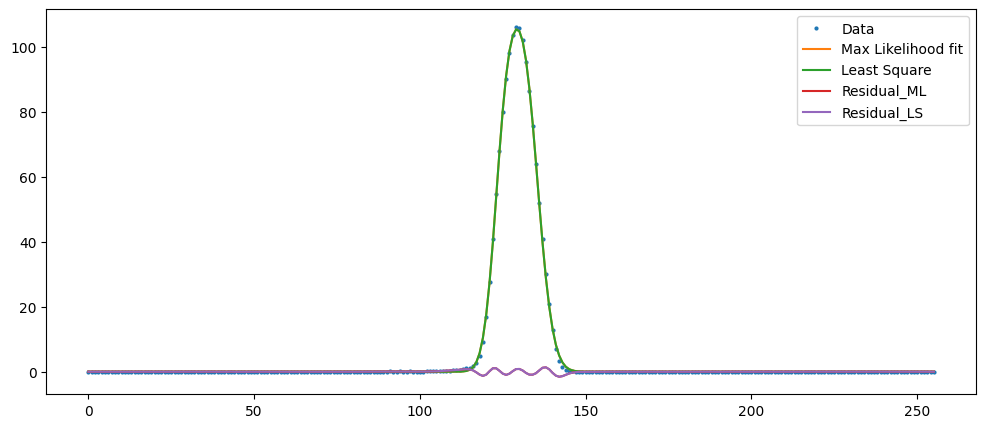

Max Likelihood 0 amp 46.484239116779214 cen 125.32845488779493 wid 3.402975180542986
Least Square 0 amp 45.88081308816073 cen 125.24797251526195 wid 3.367441495579347
Max Likelihood 1 amp 90.00775572279537 cen 131.17163921152306 wid 4.502995719763229
Least Square 1 amp 91.19031126255055 cen 131.20441046806548 wid 4.477267188420665


In [123]:
plt.figure(figsize=(12, 5))
plt.plot(spec, 'o', markersize = 2, label = 'Data')
plt.plot(ML_fit, label = 'Max Likelihood fit')
plt.plot(LS_fit, label = 'Least Square')
plt.plot(spec - ML_fit, label = 'Residual_ML')
plt.plot(spec - LS_fit, label = 'Residual_LS')
plt.legend()
plt.show()
for i in range(0, len(guess), 3):
    # print(f"Guess{i//3}", "amp", guess[i], "cen", guess[i+1], "wid", guess[i+2])
    print(f"Max Likelihood {i//3}", "amp", theta_MAP[i], "cen", theta_MAP[i+1], "wid", theta_MAP[i+2])
    print(f"Least Square {i//3}", "amp", popt[i], "cen", popt[i+1], "wid", popt[i+2])

In [124]:
# Definition of Stokes V and Stokes V correction term (including only the beta term)

def StokesV(I, alpha, beta):
    """
    Function to fit the Stokes V spectrum as a function of Stokes I and frequency
    """
    return alpha * I + beta * np.gradient(I)

def StokesVCorr(I, beta):
    """
    Stokes V correction term by fitting each Gaussain term individually
    """
    return beta * np.gradient(I)

In [125]:
# Pefroming the fit first gettin the alpha term and then the beta terms of each Gaussian
from StokesIFit import StokesIFit as StokesIFit
I_Fitter = StokesIFit(spec, 0.5)
I_fit = I_Fitter.fit()[2]
tofit = V
popt, pcov = curve_fit(StokesV, I_fit, tofit, p0=[0.1, 0.5])
tofit -= popt[0] * I_fit
bestfit = popt[0] * I_fit
print("Alpha: ", popt[0])
B = []
for i in range(0, len(I_Fitter.popt), 3):
    gauss = nGauss_scipy(np.arange(0, len(tofit), 1.), *I_Fitter.popt[i:i+3])
    popt, pcov = curve_fit(StokesVCorr, gauss, tofit, p0=[0.5])
    B.append(popt[0])

for i in range(0, len(I_Fitter.popt), 3):
    gauss = nGauss_scipy(np.arange(0, len(tofit), 1.), *I_Fitter.popt[i:i+3])
    bestfit += StokesVCorr(gauss, B[i//3])

print("Beta of each Gaussian: ", *B)


Alpha:  0.0011869276996019412
Beta of each Gaussian:  0.0010970623148243133 -0.001991863891697032


Standard Deviation: 0.028051139732063454


<Figure size 1600x700 with 0 Axes>

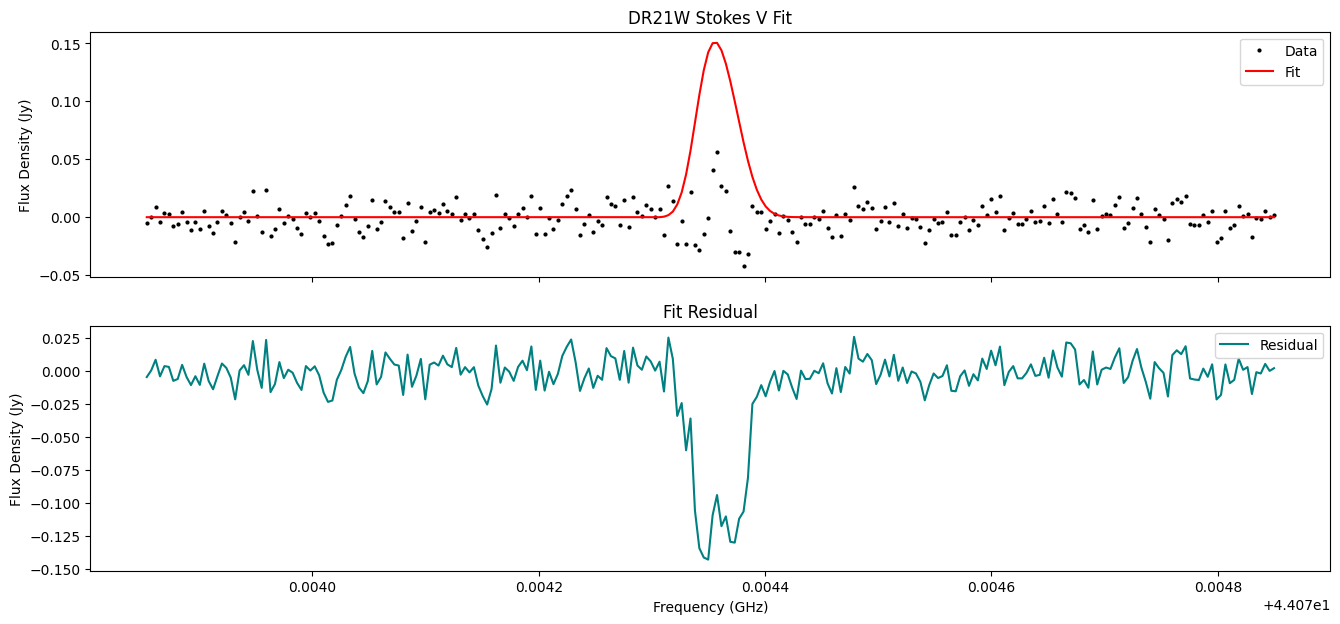

Standard Deviation 0.3134475989348954


<Figure size 1600x700 with 0 Axes>

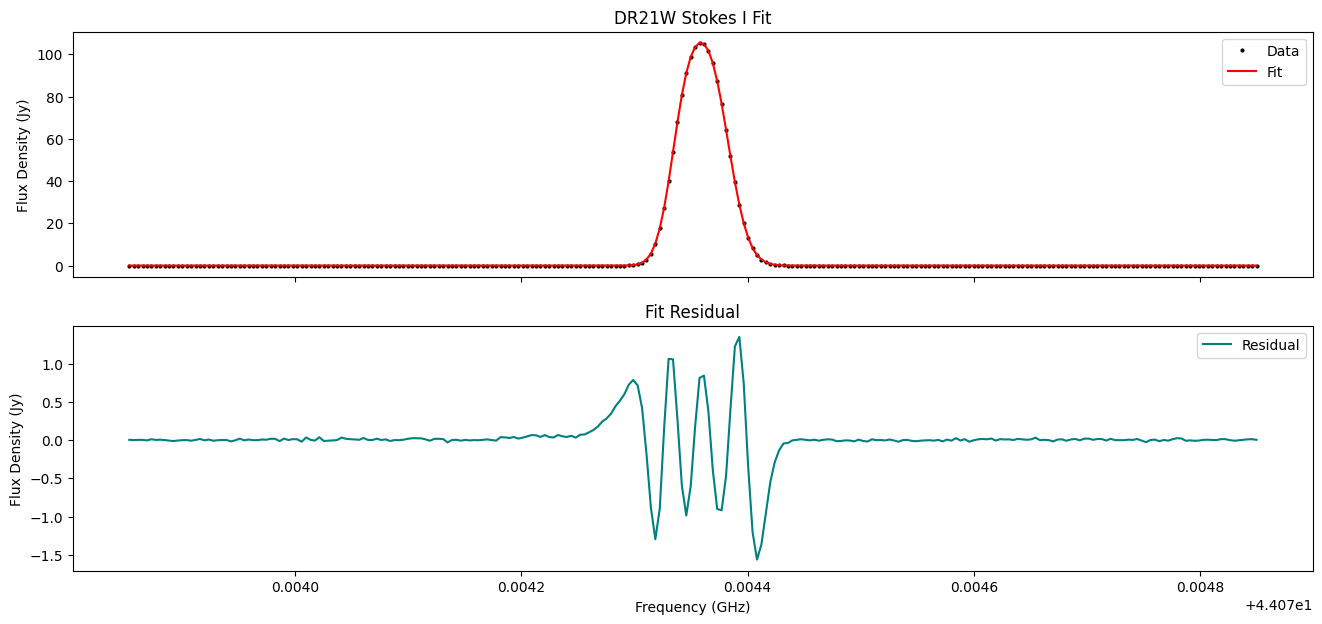

In [126]:
# Plotting
# fit = StokesV(I_fit, *popt)
fit = bestfit
print("Standard Deviation:", np.std(V-fit))
x = np.linspace(start = I_h['CRVAL3'], stop = I_h['CRVAL3'] + (I_h['NAXIS3'] - I_h['CRPIX3']) * I_h['CDELT3'], num = I_h['NAXIS3']) / 1e9
plt.figure(figsize = (16, 7))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (16, 7), sharex = True, sharey = False )
ax1.plot(x, V, 'o', color = 'k', markersize = 2, label = "Data")
ax1.plot(x, fit, color = 'red', label = "Fit")
ax1.set(title=name + " Stokes V Fit", ylabel = "Flux Density (Jy)")
ax2.plot(x, (V - fit), label = "Residual", color = 'teal')
# ax2.plot(x, fit, color = 'red', label = "Fit")
# ax2.plot(x, V, 'o', color = 'k', markersize = 2, label = "Data")
ax2.set(title="Fit Residual", xlabel="Frequency (GHz)", ylabel = "Flux Density (Jy)")
ax1.legend()
ax2.legend()
plt.show()

fit = LS_fit
y = spec
print("Standard Deviation", np.std(y-fit))
plt.figure(figsize = (16, 7))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (16, 7), sharex = True, sharey = False )
ax1.plot(x, fit, 'o', color = 'k', markersize = 2, label = "Data")
ax1.plot(x, fit, color = 'red', label = "Fit")
ax1.set(title=name + " Stokes I Fit", ylabel = "Flux Density (Jy)")
ax2.plot(x, (y-fit), label = "Residual", color = 'teal')
# ax2.plot(x, fit, label = "Fit", color = 'red')
ax2.set(title="Fit Residual", xlabel="Frequency (GHz)", ylabel = "Flux Density (Jy)")
ax1.legend()
ax2.legend()
plt.show()